## 4. Dataset osztály

A `Dataset` osztály az alapját képezi az összes kiértékelési módszernek: minden általános műveletet amit interferogramokon végezhetünk ez az osztály valósítja meg. Az itt bemutatott funkciók minden módszer esetén használhatóak (az `SPPMethod` kivételével, mivel annak az elemein használhatóak). Ehhez most szintetikus adatokat fogok használni.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysprint as ps

x = np.linspace(500, 1000, 2000)
y = np.cos(x ** 2 - 6 * x ** 3)

A `Dataset` alap konstruktora így néz ki:
```python
Dataset(x, y, ref=None, sam=None, meta=None, errors="raise")
```
`x`, `y` : Értelemszerűen az interferogram `x` és `y` értékei `np.ndarray`-ként.

`ref`, `sam` : A referencia- és tárgykar spektruma `np.ndarray`-ként (csak `y` értékek).

`meta` : A további metaadatok az interferogramról. Itt bármilyen dictionaryt beállíthatunk.

`errors` : Ha `raise`, akkor különböző hosszúságú `x` és `y` értékekre hibát ad. Ha `force`, akkor levágja a hosszabb adatsort, hogy egyező hosszúságú legyen az `x` és `y`.

A másik konstruktor a fájlból való beolvasáshoz van, ez a `parse_raw`. Ennek a szignatúrája a következő:
```python
Dataset.parse_raw(
        filename,
        ref=None,
        sam=None,
        skiprows=0,
        decimal=".",
        sep=None,
        delimiter=None,
        comment=None,
        usecols=None,
        names=None,
        swapaxes=False,
        na_values=None,
        skip_blank_lines=True,
        keep_default_na=False,
        meta_len=1,
        errors="raise"
    )
```
Itt a hosszúsága miatt nem írom le a paraméterek jelentését, minden elolvasható a `help(ps.Dataset.parse_raw)` paranccsal. Most egyszerűen `np.ndarray`-ként adom meg az adatokat. Ekkor a kiíratásnál néhány fontos adatot láthatunk.

In [2]:
d = ps.Dataset(x, y)
d.meta = {"fontos_adat_amit_be_akarok_allitani": 20}
print(d)

Dataset
----------
Parameters
----------
Datapoints: 2000
Predicted domain: wavelength
Range: from 500.000 to 1000.000 nm
Normalized: True
Delay value: Not given
SPP position(s): Not given
----------------------------
Metadata extracted from file
----------------------------
{
    "fontos_adat_amit_be_akarok_allitani": 20
}


Bár nem adtuk meg a tárgy- és a referencianyaláb spektrumát mégis kitalálta a program, hogy az interferogram normált. Minden betöltésnél ellenőrzésre kerül, hogy a megadott grafikon mekkora hányada esik kívül a [-1, 1] intervallumon, és ha az kellően kicsi, akkor normáltnak tekinti. A plottolás a plot metódussal lehetséges:

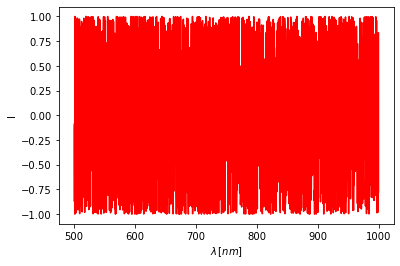

In [3]:
d.plot()
d.show() # <-- ekvivalens a plt.show függvénnyel, Jupyterben akár el is hagyható.

A teljes szignatúra a következőképpen néz ki:
```python
Dataset.plot(ax=None, title=None, xlim=None, ylim=None, **kwargs)
```
A rövidség miatt ezeket az argumentumokat itt nem részletezem. Ezekkel az opciókkal tetszőleges, akár bonyolult általunk generált grafikonokba is könnyen beágyazható és testreszabható. Alapértelmezetten a `plot` függvény nem fogja a `plt.show` függvényt meghívni, tehát Jupyter Notebookon kívül azt nekünk kell.

A következő fontos dolog a `chdomain` és a `chrange` függvények. Ezekkel egyszerűen válthatunk frekvenciatartományból hullámhossztartományba, vagy fordítva.

In [4]:
d.chdomain()
print(d)

Dataset
----------
Parameters
----------
Datapoints: 2000
Predicted domain: frequency
Range: from 1.884 to 3.767 PHz
Normalized: True
Delay value: Not given
SPP position(s): Not given
----------------------------
Metadata extracted from file
----------------------------
{
    "fontos_adat_amit_be_akarok_allitani": 20
}


Látható, hogy a fenti cella futtatása után már `Range: from 1.884 to 3.767 PHz`. Vigyázat, a `chdomain` egy inplace operáció: ha mégegyszer lefuttatjuk a fenti cellát, akkor vissza fogja váltani az eredeti tartományba. Érdemes ezt a függvényt a betöltéssel együtt ugyanabba a cellába tenni valahogyan így:
```pyhon
d = ps.Dataset(x, y)
d.chdomain()
```
Ekkor bármikor újra lefuttatjuk a cellát, akkor betöltődik újra az adatsor, és a váltás biztosan csak egyszer fog megtörténni. A függvénynek megadható az `inplace=False` opció is, erről bővebben az `FFTMethod` leírásában.

A `chrange` függvény a mértékegység átváltásra való.
```python
Dataset.chrange(current_unit, target_unit="phz")
```
Ha pl. pikométerben van az x tengelyünk, akkor nanométerbe való váltást így végezhetnénk:
```python
d.chrange(current_unit="pm", target_unit="nm")
```
Ez a függvény is támogatja az `inplace` argumentumot.


Az állandó fázisú pont módszeréhez tartozó függvényekről. Kiíratásnál látható volt, hogy
```python
Delay value: Not given
SPP position(s): Not given
```
Minden `Dataset` osztályon lehetőség van beállítani az állandó fázisú pontok helyét és a hozzá tartozó késleltetést. Ezt több módon is lehet. A legegyszerűbb:

In [5]:
d.delay = 400 # fs
d.positions = 2, 3 # PHz
print(d)

Dataset
----------
Parameters
----------
Datapoints: 2000
Predicted domain: frequency
Range: from 1.884 to 3.767 PHz
Normalized: True
Delay value: 400 fs
SPP position(s): (2, 3) PHz
----------------------------
Metadata extracted from file
----------------------------
{
    "fontos_adat_amit_be_akarok_allitani": 20
}


A `delay` mindig egy szám, a `positions` pedig tetszőleges mennyiségű szám lehet (tuple, lista, np.ndarray mind elfogadható.) Ezután a `plot` függvény is megváltozik: jelöli a megadott állandó fázisú pontok helyét.

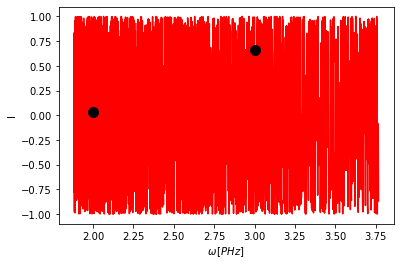

In [6]:
d.plot()

Alapértelmezetten a grafikonon nem létező helyre a program nem engedi beállítani az állandó fázisú pont helyét.

In [7]:
d.positions = 4000

ValueError: Cannot set SPP position to 4000 since it's not in the dataset's range.

Azonban a `set_SPP_data(delay, positions, force=False)` függvénnyel ezt is megtehetjük:

In [8]:
d.set_SPP_data(delay=400, positions=[4000, 2], force=True)
print(d)

Dataset
----------
Parameters
----------
Datapoints: 2000
Predicted domain: frequency
Range: from 1.884 to 3.767 PHz
Normalized: True
Delay value: 400.0 fs
SPP position(s): [4000, 2] PHz
----------------------------
Metadata extracted from file
----------------------------
{
    "fontos_adat_amit_be_akarok_allitani": 20
}


Lekérdezni az állandó fázisú pontokhoz tartozó adatokat lehetséges az `emit` függvénnyel, vagy akár egyszerűen `Dataset.delay` vagy `Dataset.positions` kiíratásával is:

In [9]:
delay, positions = d.emit()

print("Az emit függvénnyel a delay: ", delay)
print("A Dataset.delay függvénnyel: ", d.delay)

print("Az emit függvénnyel a pozíciók: ", positions)
print("A Dataset.positions függvénnyel a pozíciók: ", d.positions)


Az emit függvénnyel a delay:  [400. 400.]
A Dataset.delay függvénnyel:  [400. 400.]
Az emit függvénnyel a pozíciók:  [4000    2]
A Dataset.positions függvénnyel a pozíciók:  [4000    2]


Ekkor a `delay` pontosan ugyan olyan hosszú np.ndarray lesz, amilyen a `positions` volt, hiszen illesztésnél így kell kezelni.

A `CosFitMethod`-nál hasznos `GD_lookup(reference_point, engine="cwt", silent=False, **kwargs)` függvény elérhető már a `Dataset` osztályban is (így minden kiértékelési módszernél):

In [10]:
d.GD_lookup(reference_point=0)

The predicted GD is ± 527.51273 fs based on reference point of 0.


A következő a `slice(start, stop)` függvény. Most az alsó határt szeretném 1.9 PHz-re állítani:

In [11]:
d.slice(1.9, None) # A None változatlanul hagyja a határt. Például slice(None, 5) az alsó határt nem változtatja. 
print(d)

Dataset
----------
Parameters
----------
Datapoints: 1966
Predicted domain: frequency
Range: from 1.900 to 3.767 PHz
Normalized: True
Delay value: 400.0 fs
SPP position(s): [4000    2] PHz
----------------------------
Metadata extracted from file
----------------------------
{
    "fontos_adat_amit_be_akarok_allitani": 20
}


A tárolt adatokat a `data` függvénnyel kaphatjuk meg. Ez `pandas.DataFrame` formájában kerül visszatérítésre.

In [12]:
d.data

,x,y
0,3.767303,-0.866605
1,3.765419,-0.151222
2,3.763538,-0.084169
3,3.761658,-0.634701
4,3.759780,-0.999558
...,...,...
1961,1.901727,0.574217
1962,1.901247,-0.833038
1963,1.900767,0.858355
1964,1.900287,0.986823


Ebből konkrét értékeket `np.ndarray`-ként kinyerni a következőképpen lehet: 

In [13]:
x = d.data.x.values
print(type(x))
print(x)

<class 'numpy.ndarray'>
[3.76730313 3.76541948 3.76353771 ... 1.90076703 1.9002874  1.89980801]


#### Interaktív funkciók

Az interaktív funkciók működéséhez a
```python
with ps.interactive():
    ...
```
függvénybe (contextmanagerbe) kell az adott kódrészletet írni. A `with` blokk belsejében minden plot új ablakban nyílik meg.
Két interaktív funkciója van egy `Dataset` objektumnak, a `normalize`, illetve az `open_SPP_panel`. Amennyiben teljesen át szeretnénk váltani az *inline* plotokról, akkor a `ps.set_interactive()` függvénnyel tehetjük azt meg.

A `normalize` függvénnyel elindítható a burkológörbék megtalálásán alapuló interaktív felület, az `open_SPP_panel`-ben pedig az állandó fázisú pontokhoz tartozó adatokat tudjuk rögzíteni.

In [14]:
with ps.interactive():
    d.open_SPP_panel()

In [15]:
print(d) # véletlenszerű adatokat rögzítettem

Dataset
----------
Parameters
----------
Datapoints: 1966
Predicted domain: frequency
Range: from 1.900 to 3.767 PHz
Normalized: True
Delay value: 15.0 fs
SPP position(s): [2.99553902 3.37840899] PHz
----------------------------
Metadata extracted from file
----------------------------
{
    "fontos_adat_amit_be_akarok_allitani": 20
}


Az alábbi cellában a `normalize` függvény használom `inplace=False` módon, vagyis magát `d`-t változatlanul hagyja és visszaad egy új objektumot, amin az általam beállított normálást már elvégzi (ezt neveztem itt `g`-nek). A visszaadott objektum minden tulajdonságát örökölni fogja `d`-nek, így pl. a beállított SPP adatokat is:

In [17]:
with ps.interactive():
    g = d.normalize(inplace=False)

In [18]:
g

pysprint.core.bases.dataset.Dataset

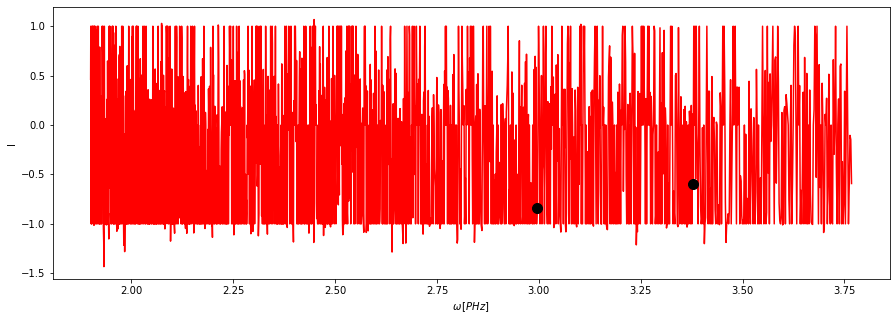

In [19]:
g.plot()

A `with ps.interactive()` fontos minden interaktív elem használata előtt. Enélkül az újabb `normalize` hívás már hibát fog adni:

AttributeError: 'NoneType' object has no attribute 'add_tool'

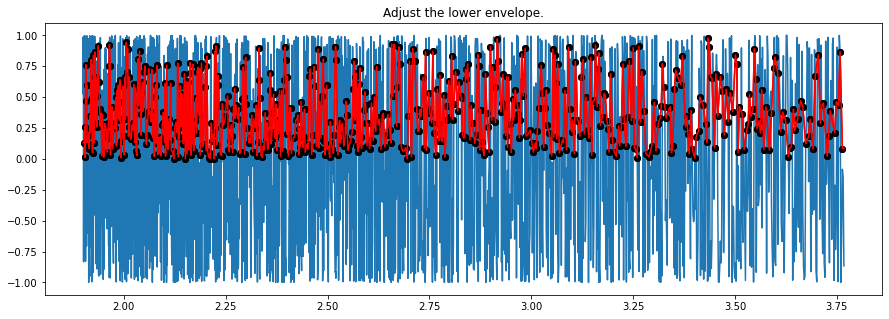

In [20]:
d.normalize()

Ezen kívül lehetőség van tetszőleges transzformációt végrehajtani az adatokon. Ehhez egy új adatsort használok a jobb láthatóság miatt.

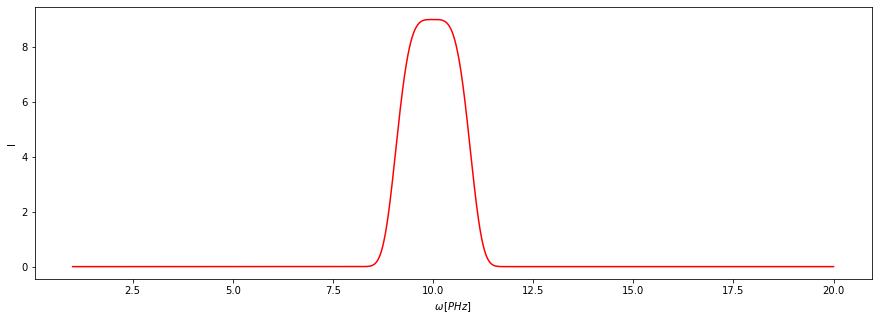

In [21]:
x = np.linspace(1, 20, 20000)
y = 9 * np.exp(-(x - 10)**4)

f = ps.Dataset(x, y)
f.plot()

Tetszőleges változtatást a `Dataset.transform(func, axis=None, args=None, kwargs=None)` függvénnyel érhetünk el. Vonjunk gyököt az `y` értékekből! Ehhez használjuk a `np.sqrt` függvényt. Könnyen ellenőrizhető a helyessége: a görbe maximuma a transzformáció után 9 helyett 3-nál van.

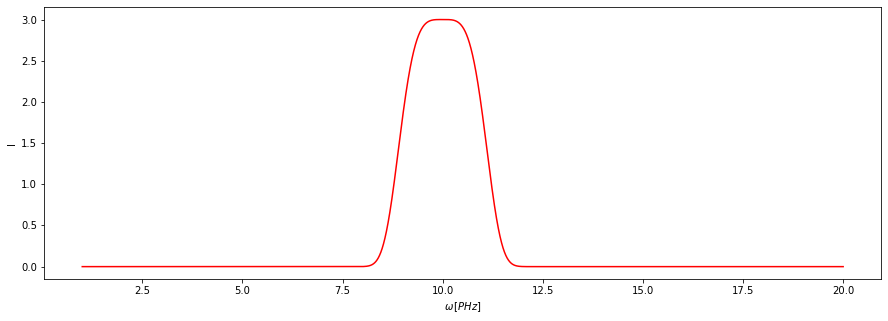

In [22]:
f.transform(np.sqrt, axis="y")
f.plot()

Lehetőség van bonyolult függvények alkalmazására is. Példaképpen készítek egyet:

In [23]:
def fuggveny(a, n, k=0.5):
    if a < n + k:
        return a
    else:
        return -a

Két kötelező argumentuma van, `a` és `n`, egy keyword argumentuma van, `k`. Ezt a következőképpen lehet alkalmazni.

`axis="y"` : Az első argumentum helyére az `y` értékeket szeretném behelyettesíteni.

`args=(1,)` : A többi kötelező argumentum értéke. Ebben az esetben úgy fordítódik le, hogy `n` legyen 1. A zárójel és a vessző fontos, mivel `tuple`-ként kell beírni.

`kwargs={"k": 0}` : A keyword argumentumok közül a `k` legyen `0`. Ez kötelezően `dictionary`.

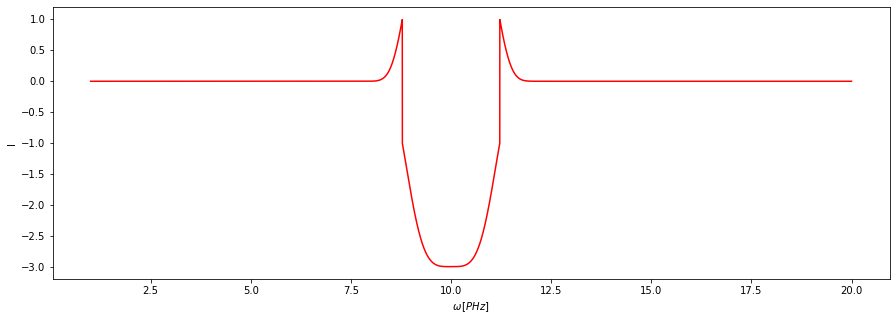

In [24]:
f.transform(fuggveny, args=(1,), kwargs={"k": 0}, axis="y")
f.plot()

Ez megfordította az előjelét azon `y` értékeknek, amik nagyobbak voltak, mint `1`.